# **Import Statements**

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from utils.data_management import Mat2TVT, Preprocessor, Custom_EMG, Jitter, MaskRand
from models.RNN_rect import EMG_RNN
from utils.training_overhead import Trainer

%load_ext autoreload
%autoreload 2

torch.cuda.is_available()

True

# **Data Reorganization** <br>


In [34]:
eye_bool = np.asarray([True, True, False, True, True, False, False, False])
electrode_list = ['u1', 'u2', 'u3', 'u4', 't2']
marker_list = ['u1', 'u2', 'u3', 'u4', 'u5']
filepath = 'eyeliddata.mat'

train = 0.7
val = 0.2
test = 0.1

reorganizer = Mat2TVT(eye_bool, electrode_list, marker_list, filepath)
_, _, identifier = reorganizer.load_data()
X, y = reorganizer.DMVC_norm()
TVT_dict = reorganizer.TVT_split(train, val, test)


X_train, y_train = TVT_dict["X_train"], TVT_dict["y_train"]
X_val, y_val = TVT_dict["X_val"], TVT_dict["y_val"]
X_test, y_test = TVT_dict["X_test"], TVT_dict["y_test"]

'''
Shape Validation
'''
#Validate shapes
print("Data Shape: ", X.shape)
print("Label Shape: ", y.shape)
print("Identifier Shape: ", identifier.shape)
assert X.shape[0] == 4564, "X Shape Invalid: Should have 4564 timesteps"
assert X.shape[2] == len(electrode_list), "X Shape Invalid: Incorrect channel count"
assert y.shape[0] == 300, "y Shape Invalid: Should have 300 timesteps"
assert y.shape[1] == 3, "y Shape Invalid: Each timestep should have 3 (cartesian) dimensions"
assert y.shape[3] == len(marker_list), "y Shape Invalid: Incorrect channel count"
assert X.shape[1] == y.shape[2] == identifier.shape[0], "Shapes Invalid: The trial dimension of X, y, and identifier needs to match"
print("Shapes Validated!")

Data Shape:  (4564, 977, 5)
Label Shape:  (300, 3, 977, 5)
Identifier Shape:  (977, 3)
Shapes Validated!


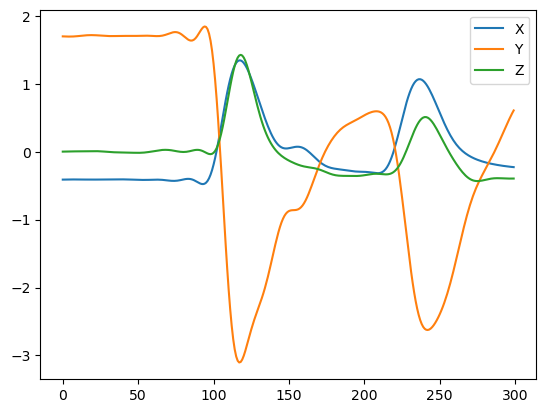

In [ ]:
c = 2
t = 300

plt.plot(y_train[:, 0, t, c], label = 'X')
plt.plot(y_train[:, 1, t, c], label = 'Y')
plt.plot(y_train[:, 2, t, c], label = 'Z')
plt.legend()
plt.show()

# **Preprocessing**

In [44]:
t_win = 20
t_lookahead = 50
t_stride = 10
batch_size = 64
p_transform = 0.3
sigma = 0.3
p_mask = 0.1

#Window and rectify the EMG data
preprocessor = Preprocessor(t_win, t_lookahead, t_stride)
X_train_wr, y_train_wr, init_state_train = preprocessor.win_rect(X_train, y_train)
X_val_wr, y_val_wr, init_state_val = preprocessor.win_rect(X_val, y_val)

#Load into custom torch.Dataset object, which applies our data augmentation (Jitter, random masking)
transform = v2.RandomApply(torch.nn.ModuleList([Jitter(sigma), MaskRand(p_mask)]), p = p_transform)

train_data = Custom_EMG(X_train_wr, y_train_wr, init_state_train, transform = transform)
train_dataloader = DataLoader(train_data, batch_size, shuffle = True)

val_data = Custom_EMG(X_val_wr, y_val_wr, init_state_val, transform = transform)
val_dataloader = DataLoader(val_data, batch_size, shuffle = True)




(trial, init), label = train_data.__getitem__(0)
print(trial.shape, init.shape, label.shape)


(train_features, init_features), train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"Initial State batch shape: {init_features.size()}")
print(train_features.device, train_labels.device, init_features.device)

torch.Size([122, 68, 5]) torch.Size([4, 3, 5]) torch.Size([4, 3, 68, 5])
Feature batch shape: torch.Size([64, 122, 68, 5])
Labels batch shape: torch.Size([64, 4, 3, 68, 5])
Initial State batch shape: torch.Size([64, 4, 3, 5])
cuda:0 cuda:0 cuda:0


In [45]:
dropout = 0.3
learning_rate = 1e-2
epochs = 15

model = EMG_RNN(train_features.size(), train_labels.size(), 2, dropout)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

trainer = Trainer(train_dataloader, val_dataloader, model, loss_fn, optimizer, batch_size, epochs)
metrics = trainer.train()

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 3167.3%, Avg Marker Error: 114.3%, Avg loss: 1.156524 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 4144.8%, Avg Marker Error: 114.3%, Avg loss: 1.064547 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 3102.0%, Avg Marker Error: 112.4%, Avg loss: 1.021289 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 3191.2%, Avg Marker Error: 113.7%, Avg loss: 1.324909 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 3167.4%, Avg Marker Error: 112.9%, Avg loss: 1.047704 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 3166.2%, Avg Marker Error: 117.3%, Avg loss: 0.925451 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 3117.9%, Avg Marker Error: 112.8%, Avg loss: 1.296926 

Epoch 8
-------------------------------
Validation Error: 
 Ma

# **Plotting Loss Metrics**

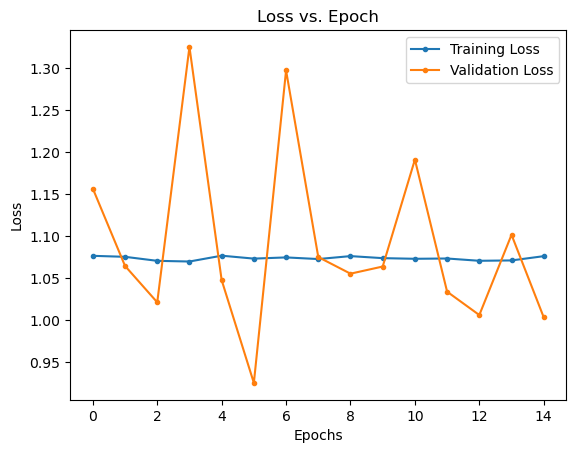

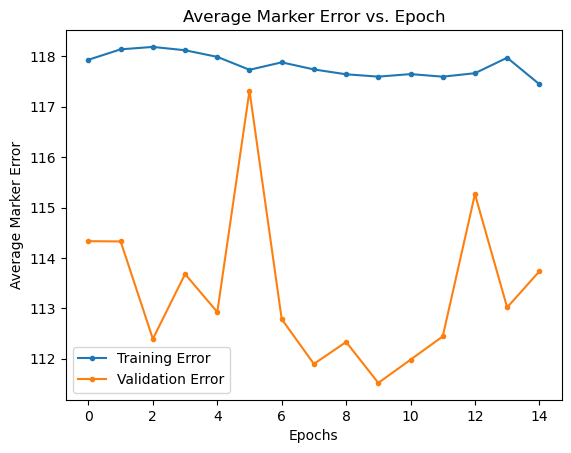

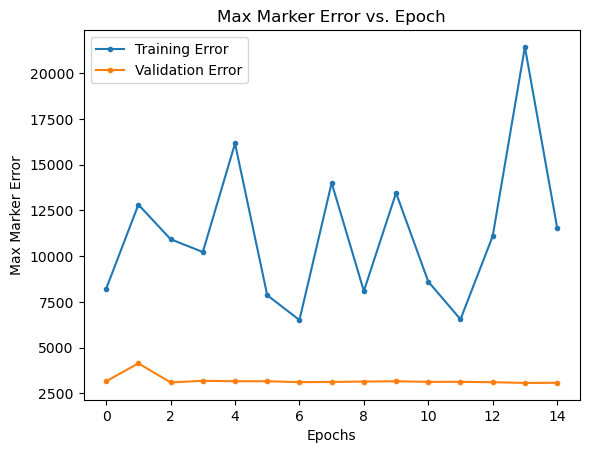

In [46]:
plt.plot(metrics['Training Loss'], label = 'Training Loss', marker = '.')
plt.plot(metrics['Validation Loss'], label = 'Validation Loss', marker = '.')
plt.title('Loss vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(metrics['Training Avg Marker Error'], label = 'Training Error', marker = '.')
plt.plot(metrics['Validation Avg Marker Error'], label = 'Validation Error', marker = '.')
plt.title('Average Marker Error vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Average Marker Error')
plt.legend()
plt.show()

plt.plot(metrics['Training Max Marker Error'], label = 'Training Error', marker = '.')
plt.plot(metrics['Validation Max Marker Error'], label = 'Validation Error', marker = '.')
plt.title('Max Marker Error vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Max Marker Error')
plt.legend()
plt.show()